**NOTE: This code needs re-examining and further revision because the currently obtained simulation results are problematic. Specifically, the inner arches at the tunnel top and bttom are expected to experience tensile stresses under the defined in-situ earth pressures, while the simulation predicts quite high compressive stresses there, which is not physical compared to the prediction given by the plasticity-based models. The problem may lie in incorrectly imposed boundary conditions, improper values of the penalty stiffness, etc.**

# Introduction
This code deals with the 2D cohesive fracture simulation of a circular tunnel made of plain concrete subjected to in-situ earth pressures transmitted by surrounding soil. An intrinsic cohesive zone model is adopted, where the solid finite elements are assumed to be linear elastic while zero-thickness joint elements whose behavior is characterized by nonlinear traction-separation laws are considered along all internal facets of the mesh. For this purpose, a Discontinuous Galerkin interpolation of the displacement field is used. Since the focus here is to analyze the response of the concrete structure, the true behavior of the soil as well as the interface interaction is disregarded for simplicity. The soil is modeled as a linear elastic body by imposing artificially large tensile strength and cohesion. The gravity is disregarded and the in-situ stresses are assumed to be uniformly distributed along the domain boundaries. The implementation is done with Firedrake, an automated system for finite element method solution, in Google Colab.

In [ ]:
# make plots appear in the notebook
%matplotlib inline 

# import necessary Python libraries
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output

# access Google Drive from Colab
from google.colab import drive
drive.mount('/content/drive')

# load Firedrake on Colab
try:
    import firedrake
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/firedrake-install-real.sh" -O "/tmp/firedrake-install.sh" && bash "/tmp/firedrake-install.sh"
    import firedrake
from firedrake import *

In [2]:
# create an output directory and make it the current one 
import os
!mkdir out_files
os.chdir('out_files')

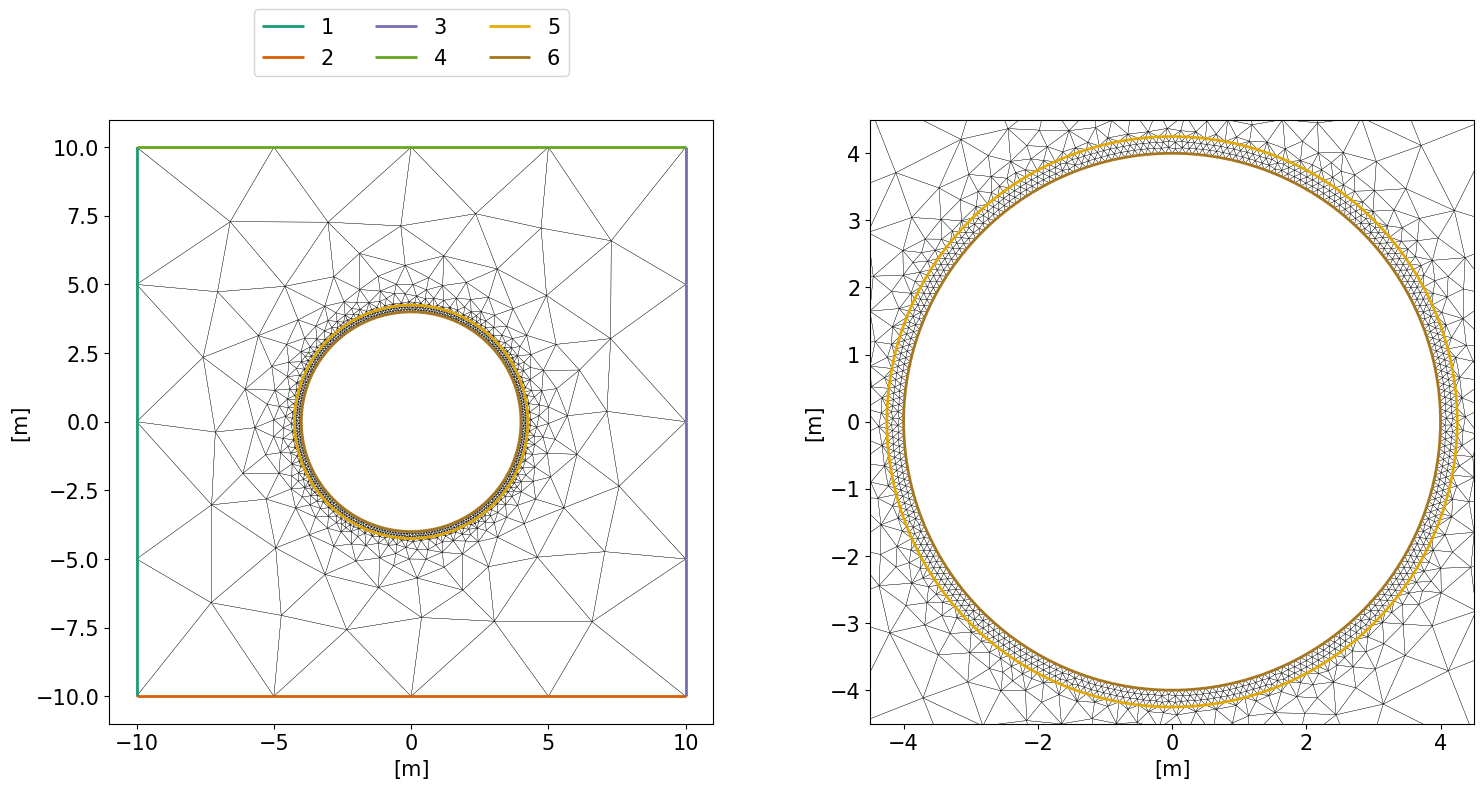

In [31]:
# domain geometry: 20 m x 20 m; tunnel geometry: internal radius = 4 m, thickness = 0.25 m
# load the mesh generated with Gmsh
mesh = Mesh('/content/drive/My Drive/Colab Notebooks/tunnel_circ_small.msh')

# plot the mesh
fig, axes = plt.subplots(1,2, figsize=(18, 8), dpi=100)
triplot(mesh, axes=axes[0], interior_kw={'linewidth': 0.2}, boundary_kw={'linewidth': 2})
axes[0].set_aspect("equal")
axes[0].legend(loc="upper center", bbox_to_anchor=(0.5, 1.2), ncol=3);
axes[0].set(xlabel='[m]', ylabel='[m]');
triplot(mesh, axes=axes[1], interior_kw={'linewidth': 0.2}, boundary_kw={'linewidth': 2})
axes[1].set_aspect("equal")
axes[1].set_xlim([-4.5, 4.5]);
axes[1].set_ylim([-4.5, 4.5]);
axes[1].set(xlabel='[m]', ylabel='[m]');
plt.rcParams.update({'font.size': 20})

# Implementation
2D linear (constant strain triangle) elements are used. "DG" (Discontinuous Galerkin) spaces are defined for the displacement (2-dimensional vector) and the stress (3-dimensional vector), while scalar quantities which live only on the mesh facets (i.e., internal variables of the traction-separation laws) are represented using a "HDiv Trace" (also known as Discontinuous Lagrange Trace) space. A piecewise constant "DG" space also serves for defining different material properties in the two subdomains representing tunnel and soil. The components in the stress vector are placed in the order: [$\sigma_{xx}$, $\sigma_{yy}$, $\tau_{xy}$]. Note that the facet functions are required to be restricted when used in forms, hence the `avg()` function and `('+')` or `('-')` are used here for the restriction purpose.

In [4]:
## define FE function spaces and functions ##
# DG: scalar discontinuous Lagrange finite elements (discontinuous piecewise polynomial functions)
# HDiv Trace: discontinuous Lagrange trace elements (polynomials living on the mesh facets which are discontinuous at the vertices)

V = VectorFunctionSpace(mesh, "DG", 1) # for discontinuous displacement vector (u)
W = VectorFunctionSpace(mesh, "DG", 1, dim=3) # for discontinuous stress tensor (sig)
P = FunctionSpace(mesh, "DG", 0) # space for piecewise constant material parameters (E, nu, sig0, c)
S = FunctionSpace(mesh, "HDiv Trace", 0) # for facet-based internal variables (dmax_n, dmax_t, gmax, flag)

u = Function(V, name="Displacement [mm]")
v = TestFunction(V)
sig = Function(W, name="Stress [MPa]")
dmax_n  = Function(S, name="Maximum normal opening [mm]")
dmax_t  = Function(S, name="Maximum tangential opening [mm]")
gmax = Function(S, name="Maximum effective opening [-]")
flag = Function(S, name="Joint state flag") # 1: active; 0: failed

dS = dS(degree=2) # interior facet integration measure
n = FacetNormal(mesh)
n_ , t_= n('-'), perp(n('-')) # restricted facet unit normal/tangential vector

In [5]:
def facet_project(v, V):
    ''' 
    Project an expression 'v' onto a facet-based function space 'V'.
    If 'v' is a dictionary of the kind {region_1: value_1, region_2: value_2, ...}, then project 
    different expressions (value_i) on subdomains with corresponding facet markers (region_i).
    The default solver parameters apply conjugate gradients as an iterative linear solver, 
    with successive over-relaxation as a preconditioner. 
    '''
    v_, dv = TestFunction(V), TrialFunction(V)
    a = inner(avg(v_), avg(dv))*dS
    if isinstance(v, dict):
        L = sum([inner(avg(v_), val)*dS(reg) for (reg, val) in v.items()])
    else:
        L = inner(avg(v_), v)*dS
    u = Function(V)
    solve(a==L, u, solver_parameters={'ksp_type': 'cg', 'pc_type': 'jacobi'})
    return u

def cell_project(v, V):
    '''
    Project an expression 'v' onto a cell-based function space 'V'.
    If 'v' is a dictionary of the kind {region_1: value_1, region_2: value_2, ...}, then project 
    different expressions (value_i) on subdomains with corresponding cell markers (region_i). 
    '''
    v_, dv = TestFunction(V), TrialFunction(V)
    a = inner(v_, dv)*dx
    if isinstance(v, dict):
        L = sum([inner(v_, val)*dx(reg) for (reg, val) in v.items()])
    else:
        L = inner(v_, v)*dx
    u = Function(V)
    solve(a == L, u)
    return u

In [6]:
# elastic parameters
# Young's modulus [Pa]
E_soil = Constant(125e6)
E_concrete = Constant(30e9)
# Poisson's ratio
nu_soil = Constant(0.2) 
nu_concrete = Constant(0.2)
# project parameter values to corresponding regions
E = cell_project({2: E_concrete, 1: E_soil}, P)
nu = cell_project({2: nu_concrete, 1: nu_soil}, P)

# Lame parameters
lmbda = E*nu/(1+nu)/(1-2*nu)
mu = E/2/(1+nu)

# strain tensor
def epsilon(u_):
    return sym(grad(u_)) # = 0.5*(grad(u_)+grad(u_).T)

# elastic stress-strain relation
def sigma(u_):
    I = Identity(u_.geometric_dimension()) # identity tensor
    return lmbda*tr(epsilon(u_))*I+2*mu*epsilon(u_)

In [7]:
## define traction-separation laws ##

# strength parameters
coef = cell_project({2: 1, 1: 1e3}, P) # a piecewise constant coefficient to impose much higher strength parameters of the soil domain (marked 1)
# uniaxial tensile strength [Pa]
sig0_concrete = 3e6 
sig0 = facet_project(sig0_concrete*coef('-'), S) # soil has a tensile strength that is 1000 times that of concrete
# internal cohesion [Pa]
c_concrete = 3e6 
c = facet_project(c_concrete*coef('-'), S)  # soil has a cohesion that is 1000 times that of concrete
# internal friction angle [degree] 
phi = Constant(np.deg2rad(35)) 

# fracture parameters
Gf1_concrete = 36 # Mode I initial fracture energy of concrete [N/m]
Gf1 = avg(facet_project(Gf1_concrete*coef('-'), S)) # soil has fracture energy that is 1000 times that of concrete
GF1 = 2.5*Gf1 # Mode I total fracture energy 
Gf2, GF2 = 4*Gf1, 4*GF1 # Mode II initial/total fracture energy

# quantities for defining bilinear mode I traction-separation law in the normal direction
pen = 2.5*E_concrete # penalty stiffness
f0_n = avg(sig0) # peak normal traction
d0_n = f0_n/pen # normal opening displacement corresponding to the peak traction
dk_n = Constant(0.016e-3) # normal opening displacement corresponding to the kink point [m]
k = 1-dk_n*f0_n/2/Gf1
fk_n = k*f0_n # normal traction corresponding to the kink point
df_n = 2*(GF1-(1-k)*Gf1)/fk_n # normal opening displacement corresponding to null traction
s1_n = (fk_n-f0_n)/(dk_n-d0_n) # slope of the first softening branch
s2_n = -fk_n/(df_n-dk_n) # slope of the second softening branch

# quantities for defining bilinear mode II traction-separation law in the tangential direction
f0_t = avg(c) # peak tangential traction (without frictional contribution)
d0_t = f0_t/pen # tangential opening displacement corresponding to the peak traction
fk_t = k*f0_t # tangential traction corresponding to the kink point
dk_t = 2*Gf2*(1-k)/f0_t # tangential opening displacement corresponding to the kink point
df_t = 2*(GF2-(1-k)*Gf2)/fk_t # tangential opening displacement corresponding to null traction
s1_t = (fk_t-f0_t)/(dk_t-d0_t) # slope of the first softening branch
s2_t = -fk_t/(df_t-dk_t) # slope of the second softening branch

# normal opening displacement
def d_n(u_):
    return dot(jump(u_), n_)

# tangential opening displacement
def d_t(u_):
    return dot(jump(u_), t_)

# effective opening 
def g(u_):
    return sqrt((pos(d_n(u_))/df_n)**2+(d_t(u_)/df_t)**2)

pos = lambda x: (x+abs(x))/2 # take the positive part of x, i.e., return x if x>0 and return 0 if x<=0

# virgin-loading definition of the traction-separation laws
def Tn_virgin(d_n): # mode I
    return conditional(d_n<=d0_n, pen*d_n, conditional(d_n<=dk_n, f0_n+s1_n*(d_n-d0_n), fk_n+s2_n*(d_n-dk_n)))                                                                                                                                       
def Tt_virgin(d_t): # mode II
    return conditional(abs(d_t)<=d0_t, pen*d_t, 
                                  sign(d_t)*(conditional(abs(d_t)<=dk_t, f0_t+s1_t*(abs(d_t)-d0_t), fk_t+s2_t*(abs(d_t)-dk_t))+pen*pos(-d_n(u))*tan(phi)))          

# unloading/reloding definition of the traction-separation laws
def Tn_ur(d_n, dmax): # mode I
    return conditional(dmax<=d0_n, pen*d_n, Tn_virgin(dmax)/dmax*d_n) 
def Tt_ur(d_t, dmax): # mode II
    return conditional(dmax<=d0_t, pen*d_t, Tt_virgin(dmax)/dmax*d_t)

# complete definition of the traction-separation laws
def Tn(d_n, dmax): # mode I
    return conditional(d_n>=dmax, Tn_virgin(d_n), Tn_ur(d_n, dmax))
def Tt(d_t, dmax): # mode II
    return conditional(abs(d_t)>=dmax, Tt_virgin(d_t), Tt_ur(d_t, dmax))

flag.assign(facet_project(1, S)) # initialize the state of all the joint elements to be active along the interior facets
T = (Tn(d_n(u), avg(dmax_n))*n_+Tt(d_t(u), avg(dmax_t))*t_)*avg(flag) # total traction vector

In [9]:
# boundary conditions: displacement constraints on the left (marked 1) & bottom (marked 2) boundaries imposed in weak form
left_bc = 100*E_soil*(0-u[0])*dot(v, -n)*ds(1)
bottom_bc = 100*E_soil*(0-u[1])*dot(v, -n)*ds(2)
# confining pressures (in-situ stresses) on the right (marked 3) & upper (marked 4) boundaries
py = 1e6 # vertical earth pressure [Pa]
px = 0.4*py # horizontal earth pressure
m = Constant(0) # load multiplier for incremental loading
F_ext = m*(px*dot(-n, v)*ds(3)+py*dot(-n, v)*ds(4)) + left_bc + bottom_bc # external virtual work

F = inner(sigma(u), epsilon(v))*dx+inner(T, jump(v))*dS - F_ext # residual form of the variational problem

# define the nonlinear problem and set the solver
problem = NonlinearVariationalProblem(F, u)
solver_parameters = {"ksp_type": "fgmres", "pc_type": "ilu"}
solver = NonlinearVariationalSolver(problem, solver_parameters=solver_parameters)

In [10]:
# represent a 2D tensor as a 3-dimensional vector
def vector_2D(X):
    return as_vector([X[0,0], X[1,1], X[0,1]])

# create output file
outfile = File("tunnel_czm_pc.pvd")
outfile.write(u, sig, time=0)
freq = 100 # output frequency (every n increments)

# set up incremental loading loop
Nincr = 500 # number of loading increments
steps = np.linspace(0, 1, Nincr+1) # pseudo-time (load) steps

sigt_top= [0] # horizontal (tensile) stress at tunnel top inner point [Pa]
sigt_bottom= [0] # horizontal (tensile) stress at tunnel bottom inner point [Pa]
sigc_left= [0] # vertical (compressive) stress at tunnel left inner point [Pa]
sigc_right= [0] # vertical (compressive) stress at tunnel right inner point [Pa]

for (i, t) in enumerate(steps[1:]):
    print("Increment:", i+1)
    m.assign(t) # increase the load multiplier step by step
    solver.solve() # solve the nonlinear equation for u
    # once convergent solution is obtained for the current load increment:
    sig.assign(project(vector_2D(sigma(u)), W)) # update stress
    dn_, dt_, g_ = facet_project(d_n(u), S), facet_project(d_t(u), S), facet_project(g(u), S) # current normal/tangential/effective opening
    # update historical maximum of normal/tangential/effective opening
    dmax_n.project(conditional(dn_>dmax_n, dn_, dmax_n))
    dmax_t.project(conditional(abs(dt_)>dmax_t, abs(dt_), dmax_t))
    gmax.project(conditional(g_>gmax, g_, gmax))
    # update joint state
    flag.assign(facet_project(conditional(avg(gmax)<1, 1, 0), S))
    # update and print the residual norm
    res = norm(assemble(F))
    print(" Residual:", res)
    clear_output(wait=True)
    # record the evolution of resulting quantities of interest
    sigt_top.append(sig([0,4])[0])
    sigt_bottom.append(sig([0,-4])[0])
    sigc_left.append(sig([-4,0])[1])
    sigc_right.append(sig([4,0])[1])
    # write output file
    if i % freq == 0:
        outfile.write(u, sig, time=t)

Increment: 150


ConvergenceError: ignored

# Post-processing

In [12]:
# take the magnitude of negative quantities
sigc_left_mag = np.zeros((len(sigc_left),1))
sigc_right_mag = np.zeros((len(sigc_right),1))
for i in range(len(sigc_left)):
    sigc_left_mag[i] = abs(sigc_left[i])
    sigc_right_mag[i] = abs(sigc_right[i])

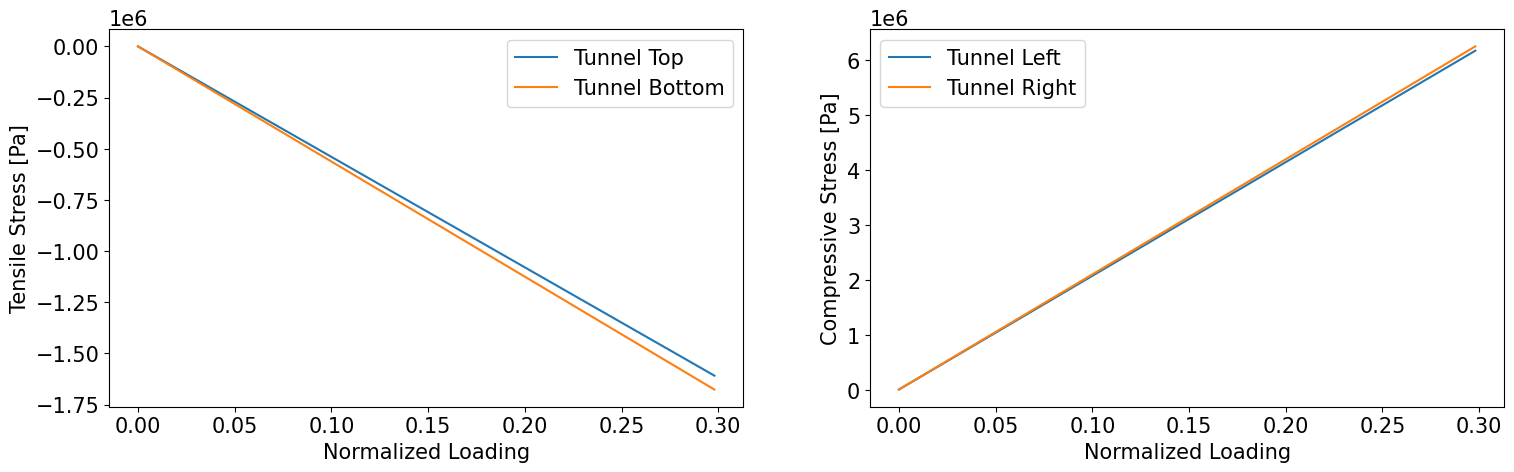

In [30]:
# plot stress evolution curves recorded at critical points in the tunnel inner arches
fig, axes = plt.subplots(1, 2, figsize=(18, 5), dpi=100)
plt.rcParams.update({'font.size': 15})
axes[0].plot(steps[:len(sigt_top)], sigt_top, steps[:len(sigt_top)], sigt_bottom, "-")
axes[0].set(xlabel='Normalized Loading', ylabel='Tensile Stress [Pa]');
axes[0].legend(['Tunnel Top', 'Tunnel Bottom'])
axes[1].plot(steps[:len(sigc_left)], sigc_left_mag, steps[:len(sigc_right)], sigc_right_mag, "-")
axes[1].set(xlabel='Normalized Loading', ylabel='Compressive Stress [Pa]');
axes[1].legend(['Tunnel Left', 'Tunnel Right'])
plt.show()

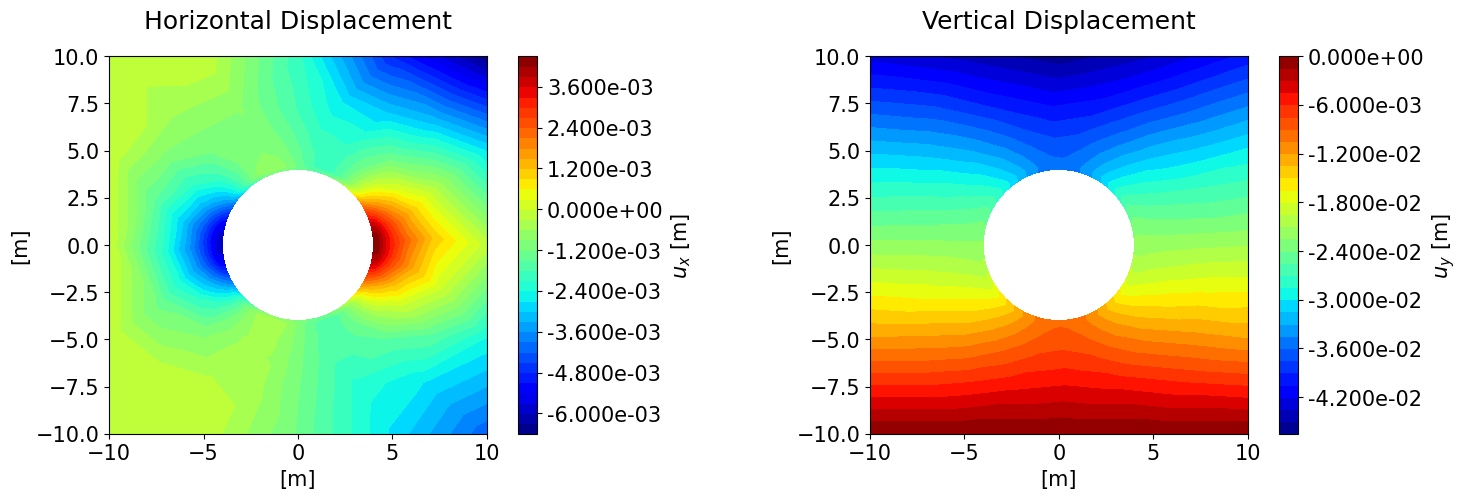

In [33]:
# plot displacement fields
fig, axes = plt.subplots(1, 2, figsize=(18, 5), dpi=100)
plt.rcParams.update({'font.size': 15})
tc = tricontourf(u.sub(0), levels=40, axes=axes[0], cmap='jet')
cb = plt.colorbar(tc, ax=axes[0], label='$u_x$ [m]', format='%.3e')
axes[0].set_title('Horizontal Displacement', pad=20)
axes[0].set_aspect("equal")
axes[0].set(xlabel='[m]', ylabel='[m]');
tc = tricontourf(u.sub(1), levels=40, axes=axes[1], cmap='jet')
cb = plt.colorbar(tc, ax=axes[1], label='$u_y$ [m]', format='%.3e')
axes[1].set_title('Vertical Displacement', pad=20)
axes[1].set_aspect("equal")
axes[1].set(xlabel='[m]', ylabel='[m]');

In [15]:
u([-10,0])

array([-1.41319559e-05, -2.20629617e-02])

In [16]:
u([0,-10])

array([-1.24313062e-03, -1.99951400e-05])

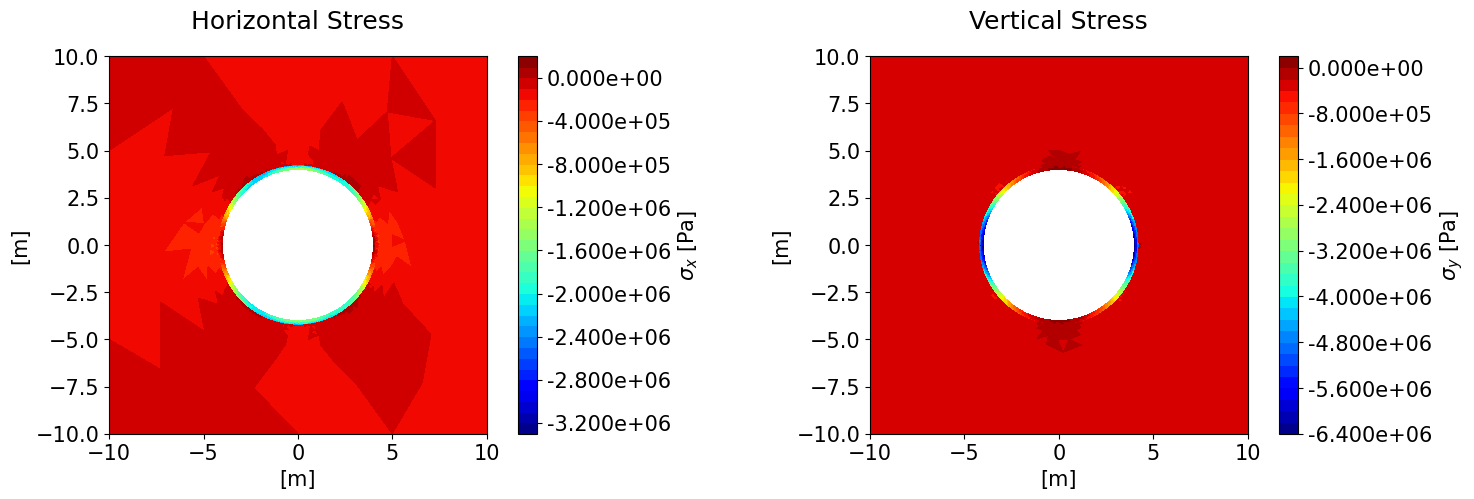

In [34]:
# plot stress fields
fig, axes = plt.subplots(1, 2, figsize=(18, 5), dpi=100)
plt.rcParams.update({'font.size': 15})
tc = tricontourf(sig.sub(0), levels=40, axes=axes[0], cmap='jet')
cb = plt.colorbar(tc, ax=axes[0], label='$\sigma_x$ [Pa]', format='%.3e')
axes[0].set_title('Horizontal Stress', pad=20)
axes[0].set_aspect("equal")
axes[0].set(xlabel='[m]', ylabel='[m]');
tc = tricontourf(sig.sub(1), levels=40, axes=axes[1], cmap='jet')
cb = plt.colorbar(tc, ax=axes[1], label='$\sigma_y$ [Pa]', format='%.3e')
axes[1].set_title('Vertical Stress', pad=20)
axes[1].set_aspect("equal")
axes[1].set(xlabel='[m]', ylabel='[m]');

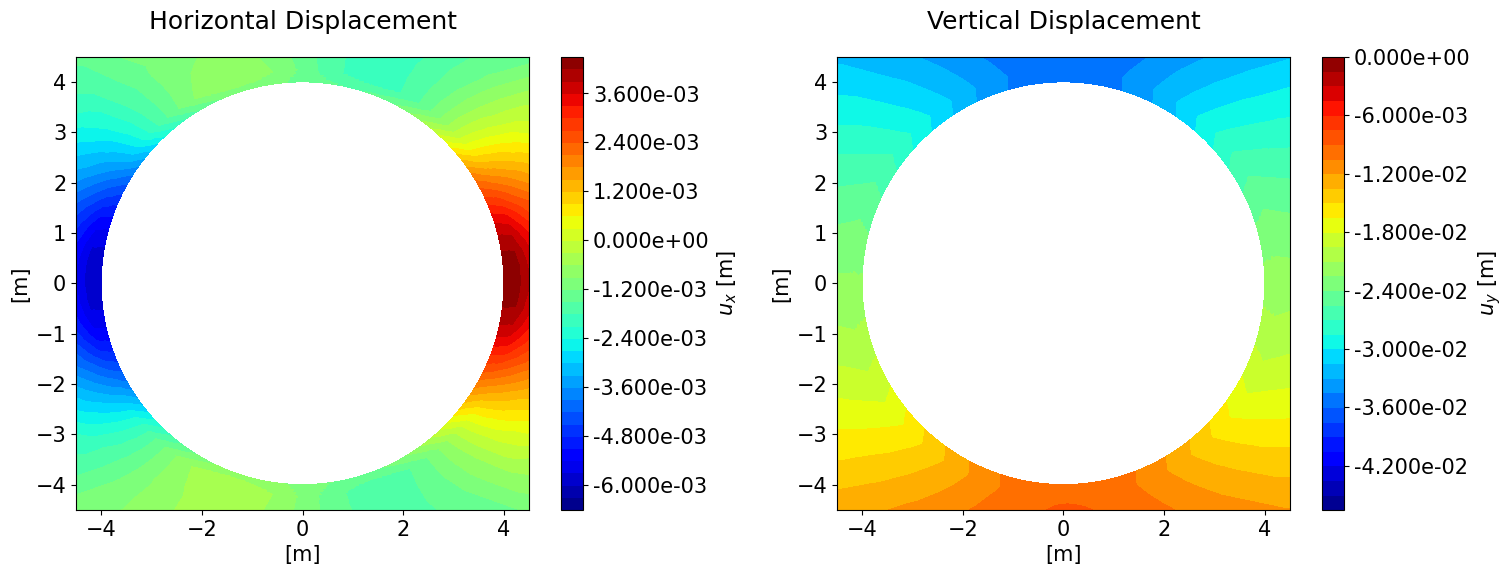

In [35]:
# plot close-up veiw of the displacement fields
fig, axes = plt.subplots(1, 2, figsize=(18, 6), dpi=100)
plt.rcParams.update({'font.size': 15})
tc = tricontourf(u.sub(0), levels=40, axes=axes[0], cmap='jet')
cb = plt.colorbar(tc, ax=axes[0], label='$u_x$ [m]', format='%.3e')
axes[0].set_title('Horizontal Displacement', pad=20)
axes[0].set_aspect("equal")
axes[0].set(xlabel='[m]', ylabel='[m]');
axes[0].set_xlim([-4.5, 4.5])
axes[0].set_ylim([-4.5, 4.5])
tc = tricontourf(u.sub(1), levels=40, axes=axes[1], cmap='jet')
cb = plt.colorbar(tc, ax=axes[1], label='$u_y$ [m]', format='%.3e')
axes[1].set_title('Vertical Displacement', pad=20)
axes[1].set_aspect("equal")
axes[1].set(xlabel='[m]', ylabel='[m]');
axes[1].set_xlim([-4.5, 4.5]);
axes[1].set_ylim([-4.5, 4.5]);

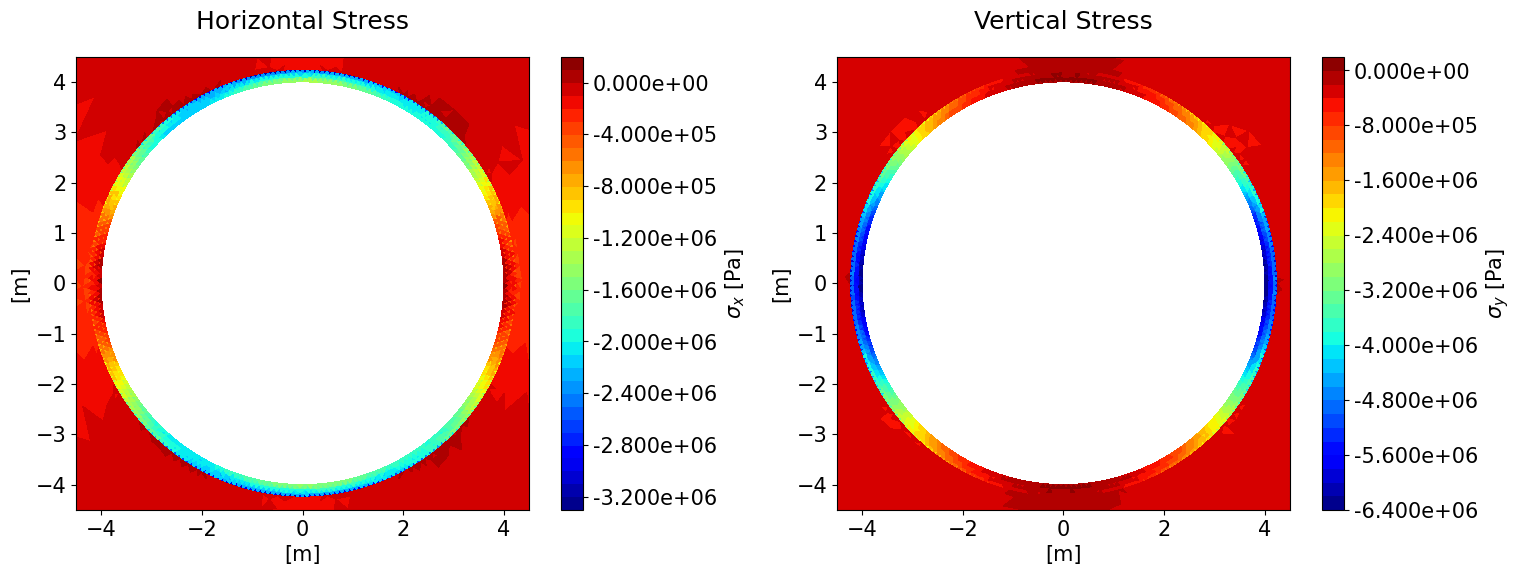

In [36]:
# plot close-up veiw of the stress fields
fig, axes = plt.subplots(1, 2, figsize=(18, 6), dpi=100)
plt.rcParams.update({'font.size': 15})
tc = tricontourf(sig.sub(0), levels=40, axes=axes[0], cmap='jet')
cb = plt.colorbar(tc, ax=axes[0], label='$\sigma_x$ [Pa]', format='%.3e')
axes[0].set_title('Horizontal Stress', pad=20)
axes[0].set_aspect("equal")
axes[0].set(xlabel='[m]', ylabel='[m]');
axes[0].set_xlim([-4.5, 4.5])
axes[0].set_ylim([-4.5, 4.5])
tc = tricontourf(sig.sub(1), levels=40, axes=axes[1], cmap='jet')
cb = plt.colorbar(tc, ax=axes[1], label='$\sigma_y$ [Pa]', format='%.3e')
axes[1].set_title('Vertical Stress', pad=20)
axes[1].set_aspect("equal")
axes[1].set(xlabel='[m]', ylabel='[m]');
axes[1].set_xlim([-4.5, 4.5]);
axes[1].set_ylim([-4.5, 4.5]);